# What's a chartist?

Recently I heard the word "chartist" for the first time in my life (that I recall).
And then later the same day, I heard it again.
So that raises two questions:

* What are the chances of going 57 years without hearing a word, and then hearing it twice in one day?

* Also, what's a chartist?

To answer the second question first, it's someone who supported chartism, which was "a working-class movement for political reform in the United Kingdom that erupted from 1838 to 1857", quoth [Wikipedia](https://en.wikipedia.org/wiki/Chartism).  The name comes from the People's Charter of 1838, which called for voting rights for unpropertied men, among other reforms.

To answer the first question, we'll do some Bayesian statistics.
My solution is based on a model that's not very realistic, so we should not take the result too seriously, but it demonstrates some interesting methods, I think.
And as you'll see, there is a connection to Zipf's law, [which I wrote about last week](https://www.allendowney.com/blog/2024/11/10/zipfs-law/).

Since last week's post was at the beginner level, I should warn you that this one is more advanced -- in rapid succession, it involves the beta distribution, the $t$ distribution, the negative binomial, and the binomial.

This post is based on *Think Bayes 2e*, which is available from
[Bookshop.org](https://bookshop.org/a/98697/9781492089469) and
[Amazon](https://amzn.to/334eqGo).

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkBayes2/blob/master/examples/zipf.ipynb).

In [1]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [2]:
# download thinkdsp.py

from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf
from utils import decorate

plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [6, 3.5]

## Word Frequencies

If you don't hear a word for more than 50 years, that suggests it is not a common word.
We can use Bayes's theorem to quantify this intuition.
First we'll compute the posterior distribution of the word's frequency, then the posterior predictive distribution of hearing it again within a day.

Because we have only one piece of data -- the time until first appearance -- we'll need a good prior distribution.
Which means we'll need a large, good quality sample of English text.
For that, I'll use a free sample of the COCA dataset from [CorpusData.org](https://www.corpusdata.org/formats.asp). The following cells download and read the data.

In [4]:
download("https://www.corpusdata.org/coca/samples/coca-samples-text.zip")

In [5]:
import zipfile


def generate_lines(zip_path="coca-samples-text.zip"):
    with zipfile.ZipFile(zip_path, "r") as zip_file:
        file_list = zip_file.namelist()
        for file_name in file_list:
            with zip_file.open(file_name) as file:
                lines = file.readlines()
                for line in lines:
                    yield (line.decode("utf-8"))

We'll use a `Counter` to count the number of times each word appears.

In [6]:
import re
from collections import Counter

pattern = r"[ /\n]+|--"

counter = Counter()
for line in generate_lines():
    words = re.split(pattern, line)[1:]
    counter.update(word.lower() for word in words if word)

The dataset includes about 188,000 unique strings, but not all of them are what we would consider words.

In [7]:
len(counter), counter.total()

(188086, 11503819)

To narrow it down, I'll remove anything that starts or ends with a non-alphabetical character -- so hyphens and apostrophes are allowed in the middle of a word.

In [8]:
for s in list(counter.keys()):
    if not s[0].isalpha() or not s[-1].isalpha():
        del counter[s]

This filter reduces the number of unique words to about 151,000.

In [9]:
num_words = counter.total()
len(counter), num_words

(151414, 8889694)

The most common words are what you would expect, with the exception of "n't", which is there because the COCA corpus treats it as a separate word.

In [10]:
counter.most_common(20)

[('the', 461991),
 ('to', 237929),
 ('and', 231459),
 ('of', 217363),
 ('a', 203302),
 ('in', 153323),
 ('i', 137931),
 ('that', 123818),
 ('you', 109635),
 ('it', 103712),
 ('is', 93996),
 ('for', 78755),
 ('on', 64869),
 ('was', 64388),
 ('with', 59724),
 ('he', 57684),
 ('this', 51879),
 ('as', 51202),
 ("n't", 49291),
 ('we', 47694)]

There are about 72,000 words that only appear once in the corpus, technically known as [hapax legomena](https://en.wikipedia.org/wiki/Hapax_legomenon).

In [11]:
singletons = [word for (word, freq) in counter.items() if freq == 1]
len(singletons), len(singletons) / counter.total() * 100

(72159, 0.811715228893143)

Here's a random selection of them. Many are proper names, typos, or other non-words, but some are legitimate but rare words.

In [12]:
np.random.choice(singletons, 100)

array(['xcor', 'metress', 'commonspace', 'attilan', 'nutritus',
       'under-estimated', 'danci', 'thoughness', 'gmulder', 'multigrade',
       'tazzarine', 'well-remembered', 'snapchat', 'yt',
       "everything'sback", 'moonclown', 'maschek', 'infront', 'meowing',
       'unhorses', 'waitressed', 'getbuckyballs.com', 'eye-rolling',
       'right.follow', 'al-maliki', 'where-it', 'candelabras',
       'trillion-dollar', 'poltically', 'way-stone', 'end-of-empire',
       'antiforgiveness', 'noncommunicative', 'astronomical-sized',
       'ms-like', 'colicky', 'mightly', 'lynsey', 'fifield',
       'consummately', 'oursega', 'steplewski', 'businessleaders',
       'pacifies', 'post-linsanity', 'high-born', 'okay.bye', 'mini-camp',
       'than-expected', 'x-lab', 'www.visitturin2006.com',
       'decreasing-there', 'kleiner', 'cosher', 'drm', 'castleman',
       'treelet', 'ostapowicz', 'gerrymander', 'kibitzing', 'resequenced',
       'goat-man', 'drenaje', 'tionist', 'betrothed', 'ca

Now let's see what the distribution of word frequencies looks like.

## Zipf's Law

One way to visualize the distribution is a Zipf plot, which shows the ranks on the x-axis and the frequencies on the y-axis.

In [13]:
freqs = np.array(sorted(counter.values(), reverse=True))

In [14]:
n = len(freqs)
ranks = range(1, n + 1)

Here's what it looks like on a log-log scale.

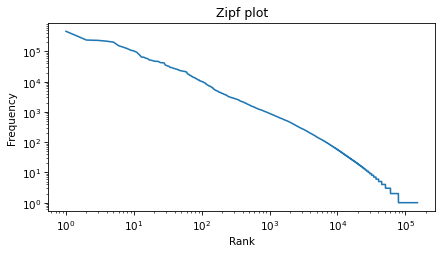

In [15]:
plt.plot(ranks, freqs)

decorate(
    title="Zipf plot", xlabel="Rank", ylabel="Frequency", xscale="log", yscale="log"
)

Zipf's law suggest that the result should be a straight line with slope close to -1.
It's not exactly a straight line, but it's close, and the slope is about -1.1.

In [16]:
rise = np.log10(freqs[-1]) - np.log10(freqs[0])
rise

-5.664633515191604

In [17]:
run = np.log10(ranks[-1]) - np.log10(ranks[0])
run

5.180166032638616

In [18]:
rise / run

-1.0935235433575892

The Zipf plot is a well-known visual representation of the distribution of frequencies, but for the current problem, we'll switch to a different representation.

## Tail Distribution

Given the number of times each word appear in the corpus, we can compute the rates, which is the number of times we expect each word to appear in a sample of a given size, and the inverse rates, which are the number of words we need to see before we expect a given word to appear.

We will find it most convenient to work with the distribution of inverse rates on a log scale.
The first step is to use the observed frequencies to estimate word rates -- we'll estimate the rate at which each word would appear in a random sample. 

We'll do that by creating a beta distribution that represents the posterior distribution of word rates, given the observed frequencies (see [this section of *Think Bayes*](https://allendowney.github.io/ThinkBayes2/chap18.html#the-conjugate-prior)) -- and then drawing a random sample from the posterior.
So words that have the same frequency will not generally have the same inferred rate.

In [19]:
from scipy.stats import beta

np.random.seed(17)
alphas = freqs + 1
betas = num_words - freqs + 1
inferred_rates = beta(alphas, betas).rvs()

Now we can compute the inverse rates, which are the number of words we have to sample before we expect to see each word once.

In [20]:
inverse_rates = 1 / inferred_rates

In [21]:
def describe(seq):
    return pd.Series(seq).describe()

In [22]:
describe(inverse_rates)

count    1.514140e+05
mean     5.232601e+06
std      1.229446e+07
min      1.922305e+01
25%      1.155947e+06
50%      2.857156e+06
75%      5.699856e+06
max      1.359491e+09
dtype: float64

And here are their magnitudes, expressed as logarithms base 10.

In [23]:
mags = np.log10(inverse_rates)

In [24]:
describe(mags)

count    151414.000000
mean          6.340519
std           0.672521
min           1.283822
25%           6.062938
50%           6.455934
75%           6.755864
max           9.133376
dtype: float64

To represent the distribution of these magnitudes, we'll use a `Surv` object, which represents survival functions, but we'll use a variation of the survival function which is the probability that a randomly-chosen value is greater than or equal to a given quantity.
The following function computes this version of a survival function, which is called a tail probability.

In [25]:
from empiricaldist import Surv


def make_surv(seq):
    """Make a non-standard survival function, P(X>=x)"""
    pmf = Pmf.from_seq(seq)
    surv = pmf.make_surv() + pmf

    # correct for numerical error
    surv.iloc[0] = 1
    return Surv(surv)

Here's how we make the survival function.

In [26]:
surv = make_surv(mags)

And here's what it looks like.

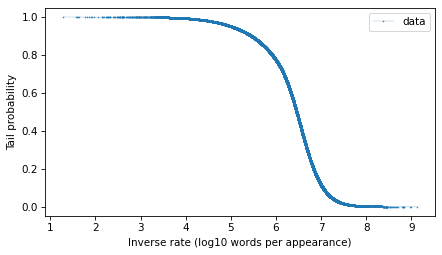

In [27]:
surv.plot(marker=".", ms=1, lw=0.2, label="data")
decorate(xlabel="Inverse rate (log10 words per appearance)", ylabel="Tail probability")

The tail distribution has the sigmoid shape that is characteristic of normal distributions and $t$ distributions, although it is notably asymmetric.

And here's what the tail probabilities look like on a log-y scale.

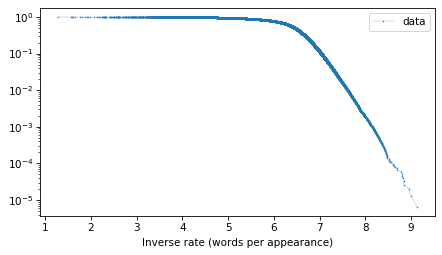

In [28]:
surv.plot(marker=".", ms=1, lw=0.2, label="data")
decorate(xlabel="Inverse rate (words per appearance)", yscale="log")

If this distribution were normal, we would expect this curve to drop off with increasing slope.
But for the words with the lowest frequencies -- that is, the highest inverse rates -- it is almost a straight line.
And that suggests that a $t$ distribution might be a good model for this data.

## Fitting a Model

To estimate the frequency of rare words, we will need to model the tail behavior of this distribution and extrapolate it beyond the data.
So let's fit a $t$ distribution and see how it looks.
I'll use code from [Chapter 8 of *Probably Overthinking It*](https://allendowney.github.io/ProbablyOverthinkingIt/longtail.html), which is all about these long-tailed distributions.

The following function makes a `Surv` object that represents a $t$ distribution with the given parameters.

In [29]:
from scipy.stats import t as t_dist


def truncated_t_sf(qs, df, mu, sigma):
    ps = t_dist.sf(qs, df, mu, sigma)
    surv_model = Surv(ps / ps[0], qs)
    return surv_model

If we are given the `df` parameter, we can use the following function to find the values of `mu` and `sigma` that best fit the data, focusing on the central part of the distribution.

In [30]:
from scipy.optimize import least_squares


def fit_truncated_t(df, surv):
    """Given df, find the best values of mu and sigma."""
    low, high = surv.qs.min(), surv.qs.max()
    qs_model = np.linspace(low, high, 1000)
    ps = np.linspace(0.1, 0.8, 20)
    qs = surv.inverse(ps)

    def error_func_t(params, df, surv):
        mu, sigma = params
        surv_model = truncated_t_sf(qs_model, df, mu, sigma)

        error = surv(qs) - surv_model(qs)
        return error

    pmf = surv.make_pmf()
    pmf.normalize()
    params = pmf.mean(), pmf.std()
    res = least_squares(error_func_t, x0=params, args=(df, surv), xtol=1e-3)
    assert res.success
    return res.x

But since we are not given `df`, we can use the following function to search for the value that best fits the tail of the distribution.

In [31]:
from scipy.optimize import minimize


def minimize_df(df0, surv, bounds=[(1, 1e3)], ps=None):
    low, high = surv.qs.min(), surv.qs.max()
    qs_model = np.linspace(low, high * 1.2, 2000)

    if ps is None:
        t = surv.ps[0], surv.ps[-5]
        low, high = np.log10(t)
        ps = np.logspace(low, high, 30, endpoint=False)

    qs = surv.inverse(ps)

    def error_func_tail(params):
        (df,) = params
        print(df)
        mu, sigma = fit_truncated_t(df, surv)
        surv_model = truncated_t_sf(qs_model, df, mu, sigma)

        errors = np.log10(surv(qs)) - np.log10(surv_model(qs))
        return np.sum(errors**2)

    params = (df0,)
    res = minimize(error_func_tail, x0=params, bounds=bounds, tol=1e-3, method="Powell")
    assert res.success
    return res.x

In [32]:
df = minimize_df(25, surv)
df

25.0
382.58404523885497
618.4159547611448
236.8319095222899
146.75213571656514
91.07977380572478
56.67236191084039
35.407411894884405
22.26495001595599
14.142461878928419
25.697947062229677
20.707337220921392
22.572143210805486
22.390897998699558
22.387674578312218
22.38696883830132
22.386635466210475
22.38630209411468
19.77327093242095
382.58404523885497
618.4159547611448
236.8319095222899
146.75213571656516
91.0797738057248
56.672361910840394
35.40741189488441
22.264950015955993
14.142461878928424
25.697947054112568
20.7073371943388
22.572143293741753
22.390897870539447
22.38767398796015
22.386983906149368
22.386650572810865
22.38731723948787


array([22.38698391])

In [33]:
mu, sigma = fit_truncated_t(df, surv)
df, mu, sigma

(array([22.38698391]), 6.430702047528606, 0.490849531484811)

Here's the `t` distribution that best fits the data.

In [34]:
low, high = surv.qs.min(), surv.qs.max()
qs = np.linspace(low, 10, 2000)
surv_model = truncated_t_sf(qs, df, mu, sigma)

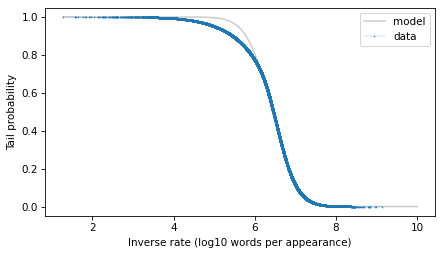

In [35]:
surv_model.plot(color="gray", alpha=0.4, label="model")
surv.plot(marker=".", ms=1, lw=0.2, label="data")
decorate(xlabel="Inverse rate (log10 words per appearance)", ylabel="Tail probability")

With the y-axis on a linear scale, we can see that the model fits the data reasonably well, except for a range between 5 and 6 -- that is for words that appear about 1 time in a million.

Here's what the model looks like on a log-y scale.

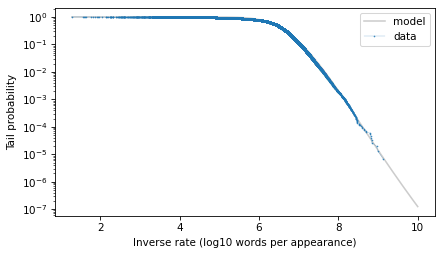

In [36]:
surv_model.plot(color="gray", alpha=0.4, label="model")
surv.plot(marker=".", ms=1, lw=0.2, label="data")
decorate(
    xlabel="Inverse rate (log10 words per appearance)",
    ylabel="Tail probability",
    yscale="log",
)

The model fits the data well in the extreme tail, which is exactly where we need it.
And we can use the model to extrapolate a little beyond the data, to make sure we cover the range that will turn out to be likely in the scenario where we hear a word for this first time after 50 years.

## The Update

The model we've developed is the distribution of inverse rates for the words that appear in the corpus and, by extrapolation, for additional rare words that didn't appear in the corpus.
This distribution will be the prior for the Bayesian update.
We just have to convert it from a survival function to a PMF (remembering that these are equivalent representations of the same distribution).

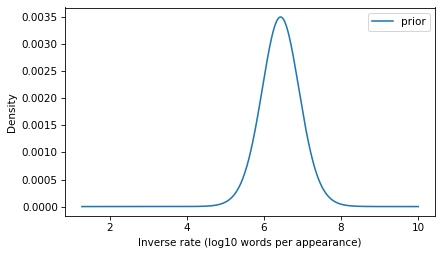

In [37]:
prior = surv_model.make_pmf()
prior.plot(label="prior")
decorate(
    xlabel="Inverse rate (log10 words per appearance)",
    ylabel="Density",
)

To compute the likelihood of the observation, we have to transform the inverse rates to probabilities.

In [38]:
ps = 1 / np.power(10, prior.qs)

Now suppose that in a given day, you read or hear 10,000 words in a context where you would notice if you heard a word for the first time.
Here's the number of words you would hear in 50 years.

In [39]:
words_per_day = 10_000
days = 50 * 365
k = days * words_per_day
k

182500000

Now, what's the probability that you fail to encounter a word in `k` attempts and then encounter it on the next attempt?
We can answer that with the negative binomial distribution, which computes the probability of getting the `n`th success after `k` failures, for a given probability -- or in this case, for  a sequence of possible probabilities.

In [40]:
from scipy.stats import nbinom

n = 1
likelihood = nbinom.pmf(k, n, ps)

With this likelihood and the prior, we can compute the posterior distribution in the usual way.

In [41]:
posterior = prior * likelihood
posterior.normalize()

1.3581072166387401e-11

And here's what it looks like.

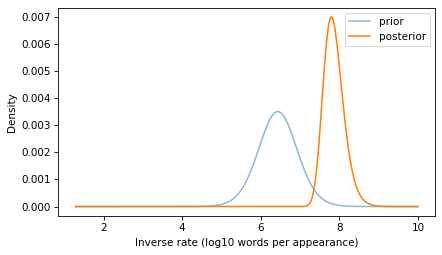

In [42]:
prior.plot(alpha=0.5, label="prior")
posterior.plot(label="posterior")
decorate(
    xlabel="Inverse rate (log10 words per appearance)",
    ylabel="Density",
)

If you go 50 years without hearing a word, that suggests that it is a rare word, and the posterior distribution reflects that logic.

The posterior distribution represents a range of possible values for the inverse rate of the word you heard.
Now we can use it to answer the question we started with: what is the probability of hearing the same word again on the same day -- that is, within the next 10,000 words you hear?

To answer that, we can use the survival function of the [binomial distribution](https://allendowney.github.io/ThinkBayes2/chap18.html?highlight=binomial#binomial-likelihood) to compute the probability of more than 0 successes in the next `n_pred` attempts.
We'll compute this probability for each of the `ps` that correspond to the inverse rates in the posterior.

In [43]:
from scipy.stats import binom

n_pred = words_per_day
ps_pred = binom.sf(0, n_pred, ps)

And we can use the probabilities in the posterior to compute the expected value -- by the law of total probability, the result is the probability of hearing the same word again within a day.

In [44]:
p = np.sum(posterior * ps_pred)
p, 1 / p

(0.00016009921991573168, 6246.1266240169725)

The result is about 1 in 6000.

With all of the assumptions we made in this calculation, there's no reason to be more precise than that.
And as I mentioned at the beginning, we should probably not take this conclusion to seriously.
If you hear a word for the first time after 50 years, there's a good chance the word is "having a moment", which greatly increases the chance you'll hear it again.
I can't think of why chartism might be in the news at the moment, but maybe this post will go viral and make it happen.

Copyright 2024 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)